In [5]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import ensemble, linear_model, svm, metrics, cluster, tree
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import scipy
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import GridSearchCV, KFold

start_time = time.time()

n_cv = 5
n_jobs = 6
random_state = 3111696
d_set = "Galaxy215-[rTRAIL.csv].tabular"

print("Processing dataset: %s" % d_set)
df = pd.read_csv("depmap/" + d_set, sep="\t")
columns = list(df.columns.values)
label = df[columns[-1]].copy()
data = df.drop(columns[-1], axis=1)
print(data.shape)
print(label.shape)

print('Training started...')

pipe_regressor = Pipeline([
  ('regression', XGBRegressor())
])

parameters = [
    {   
        #'regression__n_estimators': [50, 100],
        #'regression__max_depth': [1, 2, 3, 4, 5], \
        #'regression__booster': ['gbtree', 'gblinear', 'dart'], \
        'regression__random_state': [random_state]
    }
]

optimized_regressor = GridSearchCV(pipe_regressor, parameters, \
                                       cv=KFold(n_splits=n_cv, shuffle=True, random_state=random_state), \
                                       error_score=0, scoring='r2', verbose=True, n_jobs=n_jobs, \
                                       pre_dispatch="1*n_jobs")
optimized_regressor.fit(data, label)
best_regressor = optimized_regressor.best_estimator_
best_result = optimized_regressor.cv_results_
print(optimized_regressor.best_params_)
best_score = optimized_regressor.best_score_
print(best_score)
f_importance = optimized_regressor.best_estimator_.named_steps["regression"].feature_importances_
indices = np.argsort(f_importance)[::-1]

print('Training finished')
print("R2 square: \n", best_score)

Processing dataset: Galaxy215-[rTRAIL.csv].tabular
(604, 48117)
(604,)
Training started...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  3.5min finished
/home/anupkumar/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'regression__random_state': 3111696}
-0.09133410351545108
Training finished
R2 square: 
 -0.09133410351545108


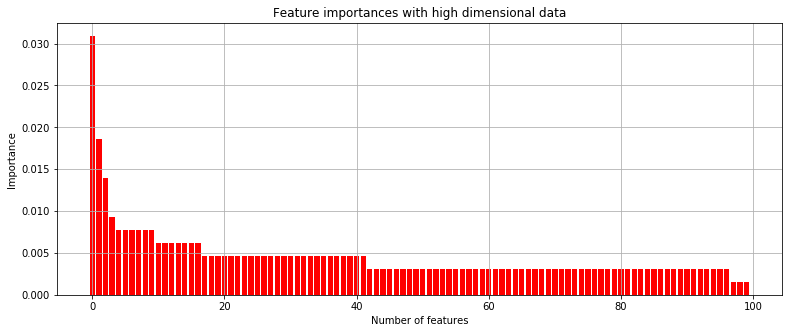

Size low dimensional data:  (604, 100)
R2 score with low dimensional data: 0.3142


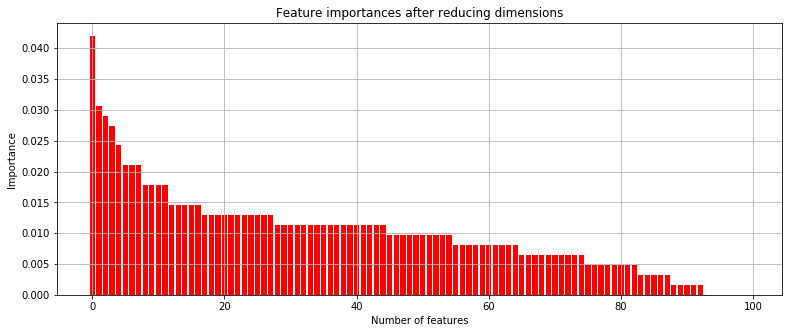

Total time taken: 5753 seconds


In [51]:
topk = 100

topk_indices = indices[:topk]

plt.figure(figsize=(13, 5))
plt.title("Feature importances with high dimensional data")
plt.bar(range(topk), f_importance[topk_indices], color="r")
plt.xlabel("Number of features")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

extracted_features_data = np.zeros([data.shape[0], topk]) 
for idx in range(topk):
    extracted_features_data[:, idx] = data.iloc[:, indices[idx]].values

print("Size low dimensional data: ", extracted_features_data.shape)
clf = XGBRegressor()
scores_ld = model_selection.cross_val_score(clf, extracted_features_data, label, cv=n_cv, scoring='r2')

print("R2 score with low dimensional data: %.4f" % np.mean(scores_ld))
    
clf.fit(extracted_features_data, label)

f_importances_ld = clf.feature_importances_
indices_ld = np.argsort(f_importances_ld)[::-1]

plt.figure(figsize=(13, 5))
plt.title("Feature importances after reducing dimensions")
plt.bar(range(topk),  f_importances_ld[indices_ld], color="r")
plt.xlabel("Number of features")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))